# Model Inference and Image Post-Processing
In this Notebook, we'll do the following.

* Apply the trained model on new images
* Use classic computer vision techniques like edge detection and contour approximation to refine segmentation boundaries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import os

In [13]:
from mmdet.apis import init_detector, inference_detector
import imageio
import matplotlib.pyplot as plt

In [4]:
model_dir = '/home/yxw4wp8/14-mmdet_2.0/mmdetection/work_dirs/kdd/mask_rcnn_r2_101'

config_file = os.path.join(model_dir, 'mask_rcnn_r2_101_fpn_2x_coco.py')
model_file = os.path.join(model_dir, 'epoch_18.pth')
model = init_detector(config_file, model_file, device='cuda:0')

print(model.CLASSES)

('door | doorframe, doorcase | double door', 'bed | bedpost | blanket, cover | headboard', 'wardrobe, closet, press', 'lamp', 'chest of drawers, chest, bureau, dresser | chest', 'pillow', 'armchair | chair | swivel chair', 'pane, pane of glass, window glass | windowpane, window', 'curtain, drape, drapery, mantle, pall', 'mirror', 'painting, picture | frame', 'wall', 'ceiling', 'floor, flooring', 'cabinet')


In [5]:
def read_image(path):
    image = imageio.imread(path)
    return image

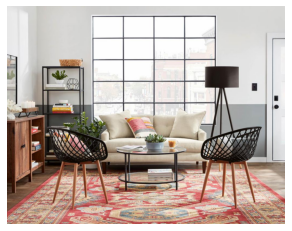

In [20]:
img = read_image('https://images.homedepot-static.com/lifestyleimages/1024x682/51ac18a1-43b8-4586-ab30-d315d67385d50.jpeg')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

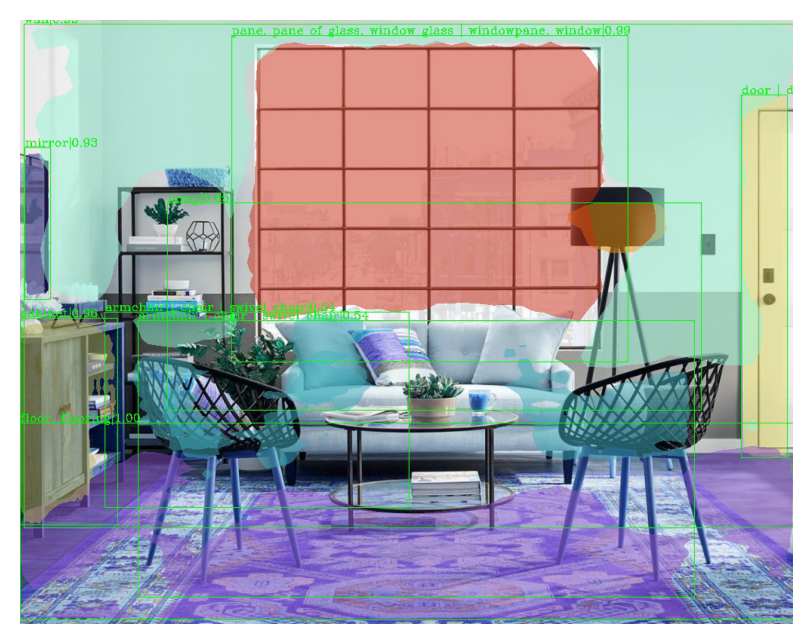

In [21]:
result = inference_detector(model, img)
model.show_result(img, result, score_thr=0.5, out_file='result.jpg')
inf = read_image('result.jpg')
fig = plt.figure(dpi=200, figsize=(8, 4))
infplot = plt.imshow(inf)
plt.axis("off")
plt.show()